In [1]:
from pathlib import Path
from tqdm import tqdm
import sys

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst

In [3]:
# Read setting file
ROOT_DIR = WORK_DIR.parent
with open(ROOT_DIR / "settings.json", "r") as f:
    settings = json.load(f)
partition = settings["partition"]
suffix = "_".join([str(n) for n in settings["Nnodes"]])
RES_DIR = WORK_DIR / "results" / f"{partition}_partition_{suffix}"
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)

In [4]:
# DFT data
dft_data = np.loadtxt("../energyvslatconst/dft_data.txt", delimiter=",")

In [5]:
##########################################################################################
# Dropout
# -------

dropout_data = np.load(
    WORK_DIR.parent
    / "training_dropout"
    / "results"
    / "dropout"
    / f"{partition}_partition_{suffix}"
    / "uncertainty_energy_vs_latconst_graphene.npz"
)
alist = dropout_data["alist"]
energy_ensembles_do = dropout_data["energy_ensembles"]
energy_mean_do = np.mean(energy_ensembles_do, axis=0)
energy_error_do = np.std(energy_ensembles_do, axis=0)

In [6]:
##########################################################################################
# Random initialization
# ---------------------
# Compute the energy ensembles
preds_samples_file = RES_DIR / "uncertainty_energy_vs_latconst_graphene.npz"
if preds_samples_file.exists():
    preds_data = np.load(preds_samples_file)
    energy_ensembles = preds_data["energy_ensembles"]
else:
    energy_ensembles = np.empty((0, len(alist)))
    for set_idx in tqdm(range(100)):
        # Predictions
        modelname = f"DUNN_C_losstraj_{set_idx:03d}"
        _, elist = energyvslatconst(modelname, alist, "graphene", 0)
        energy_ensembles = np.row_stack((energy_ensembles, elist))
    energy_ensembles = energy_ensembles.astype(float)
    np.savez(preds_samples_file, alist=alist, energy_ensembles=energy_ensembles)

In [7]:
energy_mean_lt = np.mean(energy_ensembles, axis=0)
energy_error_lt = np.std(energy_ensembles, axis=0)

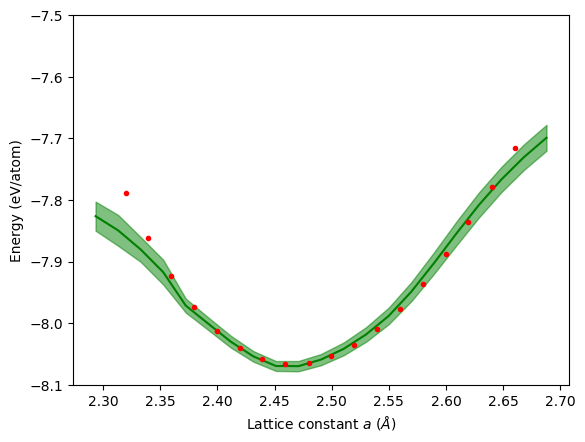

In [8]:
# Plot the result curves
# Energy vs lattice constant
plt.figure()
plt.plot(*(dft_data.T), "r.", zorder=10, label="DFT")

# Random init
plt.fill_between(
    alist,
    energy_mean_lt - energy_error_lt,
    energy_mean_lt + energy_error_lt,
    alpha=0.5,
    color="g",
    zorder=10,
)
plt.plot(alist, energy_mean_lt, "-", color="g", label="DUNN random init")

# # Dropout
# plt.fill_between(
#     alist,
#     energy_mean_do - energy_error_do,
#     energy_mean_do + energy_error_do,
#     alpha=0.5,
#     color="tab:orange",
# )
# plt.plot(alist, energy_mean_do, "-", color="tab:orange", label="DUNN dropout")
plt.ylim(-8.1, -7.5)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")
# plt.legend()

plt.show()